In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    def __init__(self, embedding_size=256, scale=30):
        """
        Gaussian Fourier projection for encoding time steps.

        Parameters
        ----------
        embedding_size: int
            Size of the Gaussian Fourier embedding.
        scale: float
            Scale factor for the time steps.
        """
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size // 2) * scale, requires_grad=False)

    def forward(self, t):
        projection = t[:, None] * self.W[None, :]
        return torch.cat([torch.sin(projection), torch.cos(projection)], dim=-1)

class ScoreNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        A simple MLP-based score network.

        Parameters
        ----------
        input_dim: int
            Input dimensionality.
        hidden_dim: int
            Hidden layer size.
        output_dim: int
            Output dimensionality.
        """
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, t):
        t_embedding = GaussianFourierProjection()(t)
        x_t = torch.cat([x, t_embedding], dim=-1)
        return self.net(x_t)

class EMA():
    def __init__(self, model, decay=0.999):
        """
        Exponential Moving Average for model parameters.

        Parameters
        ----------
        model: nn.Module
            The model whose parameters are tracked.
        decay: float
            Decay rate for the EMA.
        """
        self.model = model
        self.decay = decay
        self.shadow = {name: param.clone().detach() for name, param in model.named_parameters()}

    def update(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                self.shadow[name].sub_((1.0 - self.decay) * (self.shadow[name] - param))

    def apply(self):
        for name, param in self.model.named_parameters():
            param.data.copy_(self.shadow[name])

class DDPM(nn.Module):
    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model.

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a U-Net.
        beta_1: float
            beta_t value at t=1.
        beta_T: float
            beta_t value at t=T (last step).
        T: int
            The number of diffusion steps.
        """
        super(DDPM, self).__init__()

        self._network = network
        self.network = lambda x, t: (self._network(
            x.reshape(-1, 1, 28, 28), (t.squeeze() / T))
        ).reshape(-1, 28 * 28)

        self.T = T
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T + 1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

    def forward_diffusion(self, x0, t, epsilon):
        """
        q(x_t | x_0): Forward diffusion process.
        """
        alpha_bar_t = self.alpha_bar[t].view(-1, 1)
        mean = torch.sqrt(alpha_bar_t) * x0
        std = torch.sqrt(1 - alpha_bar_t)
        return mean + std * epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t): Reverse diffusion process.
        """
        beta_t = self.beta[t].view(-1, 1)
        alpha_t = self.alpha[t].view(-1, 1)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1)
        alpha_bar_prev = self.alpha_bar[t - 1].view(-1, 1) if t > 1 else torch.tensor(1.0)

        mean = (torch.sqrt(alpha_bar_prev) * xt - beta_t * epsilon) / torch.sqrt(alpha_bar_t)
        std = torch.sqrt(beta_t)
        return mean + std * epsilon


In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Simple example network: a very basic neural network used by DDPM
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, x, t):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x

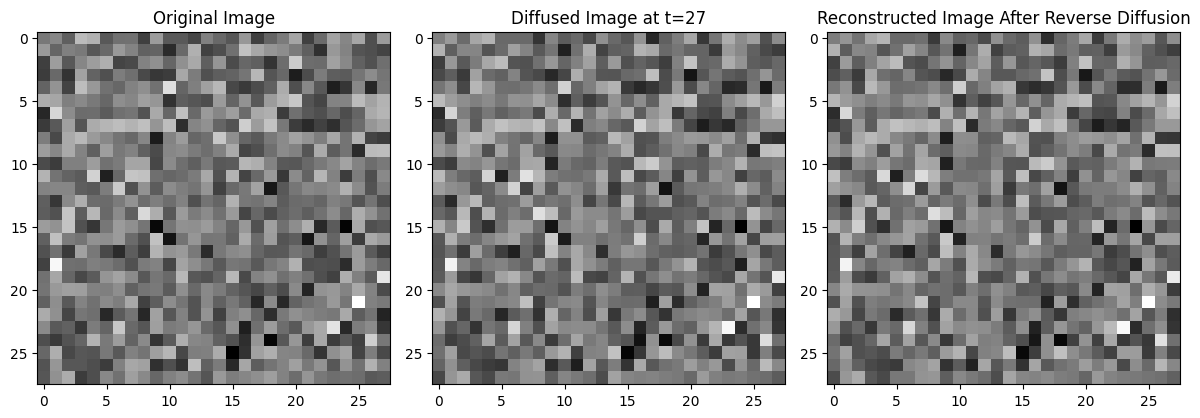

In [8]:
# Instantiate the DDPM model
T = 100  # Number of diffusion steps
network = SimpleUNet()
model = DDPM(network, T=T)

# Generate a random initial image (size 28x28) and a random noise epsilon
x0 = torch.randn(1, 1, 28, 28)  # Example: Single 28x28 image, batch size 1
epsilon = torch.randn(1, 1, 28, 28)  # Random noise

# Pick a random timestep t
t = torch.randint(1, T, (1,)).item()

# Apply forward diffusion
xt = model.forward_diffusion(x0, t, epsilon)

# Visualize the original image, noisy image, and diffusion process at step t
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(x0.squeeze().detach().numpy(), cmap="gray")

# Diffused image at time t
plt.subplot(1, 3, 2)
plt.title(f"Diffused Image at t={t}")
plt.imshow(xt.squeeze().detach().numpy(), cmap="gray")

# Reverse diffusion (using a random noise sample epsilon)
epsilon_reverse = torch.randn(1, 1, 28, 28)  # New random noise for reverse diffusion
xt_reverse = model.reverse_diffusion(xt, t, epsilon_reverse)

# Reconstructed image after reverse diffusion
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image After Reverse Diffusion")
plt.imshow(xt_reverse.squeeze().detach().numpy(), cmap="gray")

plt.tight_layout()
plt.show()